Using device: cpu

Starting Autoencoder Pre-training...
Epoch [1/20], Reconstruction Loss: 0.053357
Epoch [2/20], Reconstruction Loss: 0.025694
Epoch [3/20], Reconstruction Loss: 0.019805
Epoch [4/20], Reconstruction Loss: 0.016417
Epoch [5/20], Reconstruction Loss: 0.014220
Epoch [6/20], Reconstruction Loss: 0.012661
Epoch [7/20], Reconstruction Loss: 0.011411
Epoch [8/20], Reconstruction Loss: 0.010422
Epoch [9/20], Reconstruction Loss: 0.009722
Epoch [10/20], Reconstruction Loss: 0.009203
Epoch [11/20], Reconstruction Loss: 0.008765
Epoch [12/20], Reconstruction Loss: 0.008383
Epoch [13/20], Reconstruction Loss: 0.008037
Epoch [14/20], Reconstruction Loss: 0.007751
Epoch [15/20], Reconstruction Loss: 0.007507
Epoch [16/20], Reconstruction Loss: 0.007293
Epoch [17/20], Reconstruction Loss: 0.007099
Epoch [18/20], Reconstruction Loss: 0.006916
Epoch [19/20], Reconstruction Loss: 0.006752
Epoch [20/20], Reconstruction Loss: 0.006597
Autoencoder Pre-training Finished.

Extracting latent

c:\Users\mahin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE transformation finished.


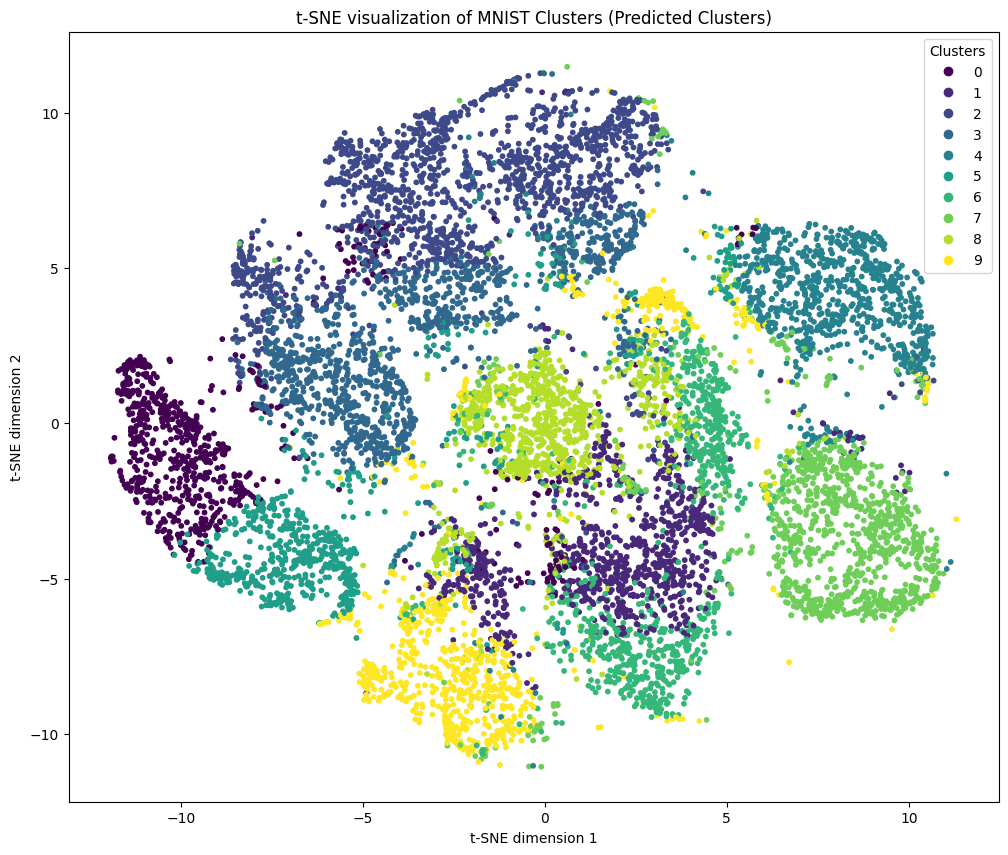

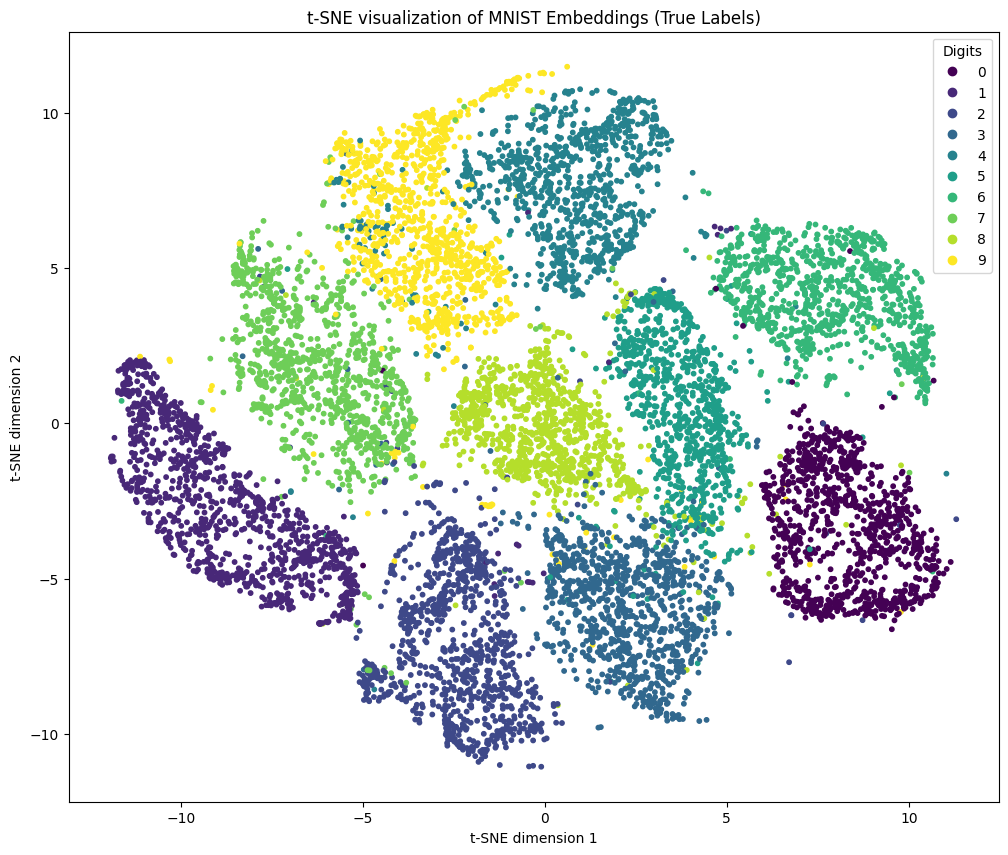


--- Script Finished ---


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration & Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Autoencoder hyperparameters
input_size = 784  # 28x28 images flattened
hidden_dim1 = 256
hidden_dim2 = 128
latent_dim = 32   # Dimension of the latent space for clustering
ae_learning_rate = 1e-3
ae_epochs = 20    # Epochs for pre-training the autoencoder
batch_size = 128

# Clustering hyperparameters
num_clusters = 10 # MNIST has 10 digits

# --- 1. Dataset and Dataloaders ---
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)) # MNIST mean and std
    # For AE, often better to keep pixels in [0,1] or use Tanh for output in [-1,1]
    # Let's keep them in [0,1] for simplicity with MSE loss and Sigmoid output
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True) # For evaluation

# We'll use the full training set to learn embeddings and then cluster
# For final evaluation of clustering quality, we can use the test set embeddings
full_dataset_loader = DataLoader(
    datasets.MNIST(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size,
    shuffle=False # Important for consistent order when extracting embeddings
)

# Test loader for evaluating on unseen data embeddings
test_loader_for_embeddings = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


# --- 2. Autoencoder Model Definition ---
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_dim1, hidden_dim2, latent_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim) # Latent space representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_size),
            nn.Sigmoid()  # To output values between 0 and 1, matching input
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

autoencoder = Autoencoder(input_size, hidden_dim1, hidden_dim2, latent_dim).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=ae_learning_rate)

# --- 3. Pre-training the Autoencoder ---
print("\nStarting Autoencoder Pre-training...")
autoencoder.train()
for epoch in range(ae_epochs):
    total_loss = 0
    for data, _ in full_dataset_loader: # No need for labels here
        img = data.view(data.size(0), -1).to(device) # Flatten images
        
        recon, _ = autoencoder(img)
        loss = criterion_ae(recon, img)
        
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(full_dataset_loader)
    print(f"Epoch [{epoch+1}/{ae_epochs}], Reconstruction Loss: {avg_loss:.6f}")
print("Autoencoder Pre-training Finished.")

# --- 4. Extracting Latent Embeddings ---
print("\nExtracting latent embeddings...")
autoencoder.eval()
all_embeddings = []
all_labels = []

# Use the test set for clustering evaluation to see how well it generalizes
# Or use training set if you want to cluster the data you trained on
# Let's use the test set for a more robust evaluation of clustering quality
with torch.no_grad():
    for data, labels in test_loader_for_embeddings:
        img = data.view(data.size(0), -1).to(device)
        _, encoded_output = autoencoder(img)
        all_embeddings.append(encoded_output.cpu().numpy())
        all_labels.append(labels.numpy())

embeddings_array = np.concatenate(all_embeddings, axis=0)
true_labels_array = np.concatenate(all_labels, axis=0)
print(f"Extracted embeddings shape: {embeddings_array.shape}")
print(f"True labels shape: {true_labels_array.shape}")


# --- 5. Clustering with K-Means ---
print("\nPerforming K-Means clustering on embeddings...")
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
cluster_assignments = kmeans.fit_predict(embeddings_array)
print("K-Means Clustering Finished.")

# --- 6. Evaluation Metrics ---
print("\nEvaluating Clustering Performance...")

# Silhouette Score (higher is better)
# Can be slow for large datasets, may sample if needed
# For 10k samples (MNIST test set), it should be acceptable
sil_score = silhouette_score(embeddings_array, cluster_assignments)
print(f"Silhouette Score: {sil_score:.4f}")

# Davies-Bouldin Index (lower is better)
db_index = davies_bouldin_score(embeddings_array, cluster_assignments)
print(f"Davies-Bouldin Index: {db_index:.4f}")

# Since MNIST has true labels, we can also calculate metrics that use them
# Adjusted Rand Index (ARI) (higher is better, 1 is perfect)
ari_score = adjusted_rand_score(true_labels_array, cluster_assignments)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")

# Normalized Mutual Information (NMI) (higher is better, 1 is perfect)
nmi_score = normalized_mutual_info_score(true_labels_array, cluster_assignments)
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

# --- 7. Visualization with t-SNE ---
print("\nVisualizing clusters with t-SNE (this may take a moment)...")
# Reduce dimensionality for visualization using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300) # Lower n_iter for speed
embeddings_tsne = tsne.fit_transform(embeddings_array)
print("t-SNE transformation finished.")

plt.figure(figsize=(12, 10))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=cluster_assignments, cmap='viridis', s=10)
plt.title('t-SNE visualization of MNIST Clusters (Predicted Clusters)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(handles=scatter.legend_elements()[0], labels=list(range(num_clusters)), title="Clusters")
plt.show()

# Optional: Visualize with true labels for comparison
plt.figure(figsize=(12, 10))
scatter_true = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=true_labels_array, cmap='viridis', s=10) # Use 'tab10' for distinct colors if preferred
plt.title('t-SNE visualization of MNIST Embeddings (True Labels)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend(handles=scatter_true.legend_elements()[0], labels=list(range(num_clusters)), title="Digits")
plt.show()

print("\n--- Script Finished ---")